1. California 집 값 예측에 사용할 데이터입니다. 이 데이터는 [Kaggle](https://www.kaggle.com/harrywang/housing) 에서 얻을 수 있습니다. 이 데이터는 *핸즈 온 머신러닝*에서 사용한 데이터입니다.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터를 로드하여 DataFrame에 저장합니다.
housing_data = pd.read_csv('./input/housing.csv')

In [3]:
# 데이터를 살펴봅니디.
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


모델링의 목표는 median_income을 예측하는 것입니다. 

In [4]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


25번째 백분위수(제1사분위수), 중간값, 75번째 백분위수(제3사분위수)

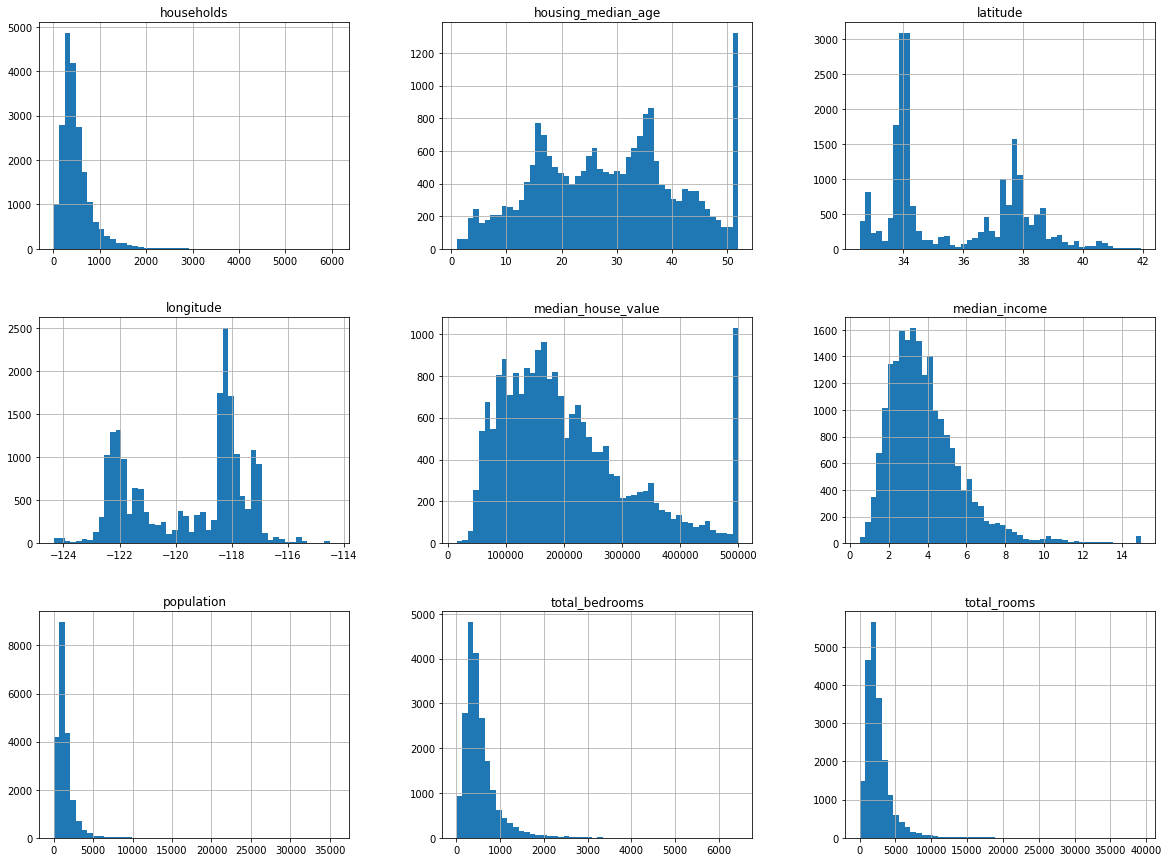

In [10]:
housing_data.hist(bins=50, figsize=(20, 15))
plt.show()

**데이터 스누핑**을 방지하기 위하여, test set을 train set과 명확하게 분리합니다. 이미 모델에 노출된 test set을 이용하여 모델을 선택한다면 매우 낙관적인 추정이 되어 기대한 성능이 나오지 않습니다. Test set은 전체 data set에서 중요한 특성의 카테고리를 잘 대표해야 합니다.

In [24]:
# Median income에서 골고루 test set을 뽑기 위하여, median income을 1~5의 카테고리로 나눕니다.
housing_data['income_cat'] = np.ceil(housing_data['median_income'] / 1.5)
housing_data['income_cat'].where(housing_data['income_cat'] < 5, 5.0, inplace=True)

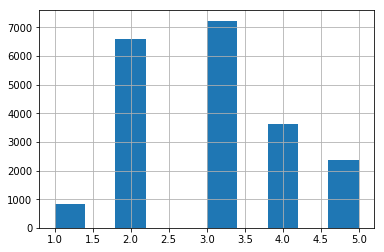

In [25]:
housing_data['income_cat'].hist()

Train set과 test set을 나눕니다.

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_idx]
    strat_test_set = housing_data.loc[test_idx]

In [34]:
# Data set에서 income category의 비율
housing_data['income_cat'].value_counts() / len(housing_data)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [36]:
# Train set에서 income category의 비율
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [37]:
# Test set에서 income category의 비율
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [38]:
for _set in ([strat_train_set, strat_test_set]):
    _set.drop('income_cat', axis=1, inplace=True)

데이터 탐색과 시각화(Exploratory data analysis)입니다. 훈련 세트가 매우 크면 조작을 간단하고 빠르게 하기 위해 탐색을 위한 세트를 별도로 샘플링할 수 있습니다.

In [40]:
eda_train_set = strat_train_set.copy()

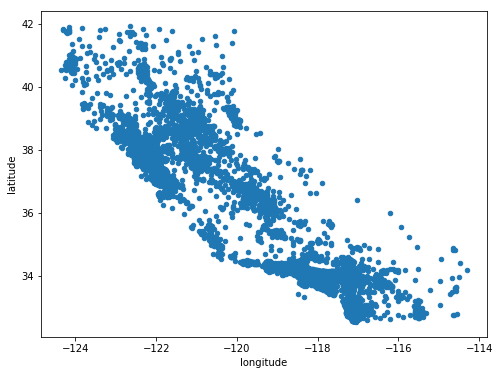

In [48]:
# 지리 정보(위도, 경도)가 있으므로 산점도 데이터 시각화를 합니다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(8, 6), fontsize=10, )

Scatter의 형태는 캘리포니아를 잘 나타내지만, 특별한 패턴을 찾기는 힘듭니다.

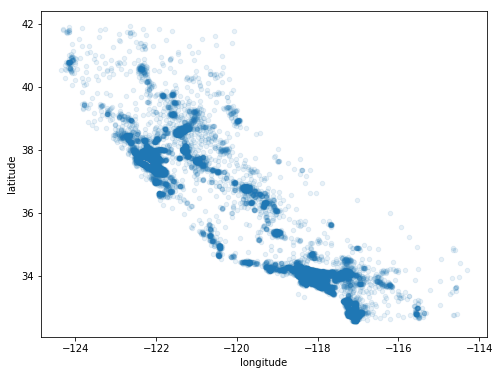

In [50]:
# 밀집된 지역을 나타냅니다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(8, 6), fontsize=10,  alpha=0.1)

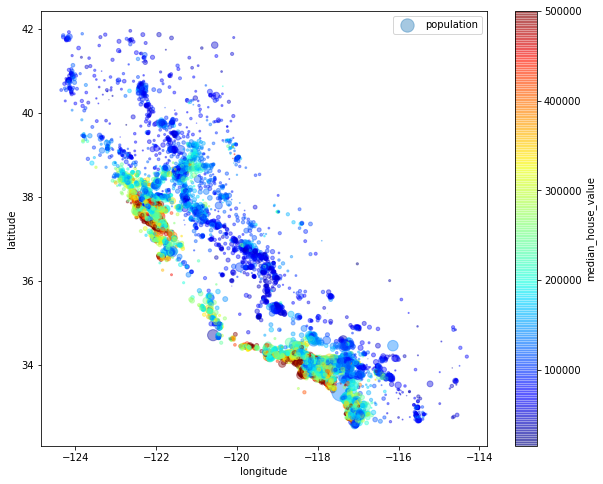

In [56]:
# 인구수는 scatter의 반지름 크기로 나타내고(s), 집 값은 scatter의 색깔을 나타낸다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(10, 8), fontsize=10, alpha=0.4,
                   s=eda_train_set['population']/100, label='population', c='median_house_value',
                   cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)
plt.legend()

주택 가격은 위치(바다와 가까운 곳일 수록 높다)와 인구 밀도에 관련이 있다고 볼 수 있습니다.

상관관계(피어슨의 r)를 조사합니다.

In [57]:
corr_matrix = eda_train_set.corr()

In [59]:
# 중간 주택 가격과 다른 특성 사이의 상관관계를 살펴본다.
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64